# Indoor Heating Efficiency Model

### Physical conclusions

 - Heat is all on or all off; no concept of something like a heating element heating up or cooling down. This could mean a gas furnace is used.
 - There was a period where the system either was broken or turned off. 
 - Low efficiency intervals were worse and more common later in the season.


### Suggestions for Improving Accuracy

 - Account for heat generated by people, lights, appliances
 - Account for variations in R, such as where the building is underground
 - Derive R and C from the data as discussed here: http://www.sciencedirect.com/science/article/pii/S0378778814003041

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt("data/thermostat_1_1_.csv", delimiter = ",")

In [3]:
class efficiency_model():
    def __init__(self, data, R, C):
        self.data = data
        self.R = R
        self.C = C
   
    def S(self, t):
        # if heat was on for more than half of the interval, S_t = 1
        if self.data[:,5][t] > 150:
            S_t = 1
        else:
            S_t = 0

        return S_t

    
    def heating_energy(self, dTin_dt, T_diff, S_t, R, C):
        if S_t != 0:
            Qh_t_over_C = (dTin_dt - (T_diff / (R*C))) / S_t
        else: 
            Qh_t_over_C = 0
        
        return Qh_t_over_C

    
    def energy_over_time(self):
        self.Qh_over_C = [] # time series in question will go in this list
        self.variables = [] # storage for later testing
        T_in = self.data[:,1] 
        T_out = self.data[:,7]
        
        # calculate the target value for all t
        for t in range(len(data)-1):
            t += 1
            S_t = self.S(t)
            dTin_dt = T_in[t] - T_in[t-1]
            T_diff = T_out[t] - T_in[t]
            variables_t = [dTin_dt, T_diff, S_t]
            self.variables.append(variables_t)
            Qh_t_over_C = self.heating_energy(dTin_dt, T_diff, S_t, R, C)
            self.Qh_over_C.append(Qh_t_over_C)
        
        return self.Qh_over_C
    
    
    def test_model(self):
        test_dTin_dt = []
        variables = np.array(self.variables)
        dTin_dt = variables[:,0]
        T_diff = variables[:,1]
        S = variables[:,2]
        Qh_over_C = self.Qh_over_C 
        R = self.R
        C = self.C
        
        for t in range(len(self.variables)):
            test_t = (T_diff[t] / (R*C)) + (S[t]*Qh_over_C[t])
            #print(test_t, T_diff[t] / (R*C), S[t], Qh_over_C[t])
            test_dTin_dt.append(test_t)
         
        test_dTin_dt = np.array(test_dTin_dt).reshape(len(self.variables),1)
        dTin_dt = dTin_dt.reshape(len(self.variables),1)
        
        return test_dTin_dt, dTin_dt
    
    def diagnostic_plots(self):
        fig, axarr = plt.subplots(4, 1, figsize=(20, 30))
        fig.suptitle("Diagnostic Plots", fontsize=30)

        axarr[0].plot(data[:,1])
        axarr[0].plot(data[:,7])
        axarr[0].set_title('Indoor vs. Outdoor Temp', fontsize=20)
        axarr[1].plot(Qh_over_C)
        axarr[1].set_title('Qh_over_C', fontsize=20)
        axarr[2].plot(test_dTin_dt)
        axarr[2].set_title('Calculated Indoor Temp Rate of Change', fontsize=20)
        axarr[3].plot(true_dTin_dt)
        axarr[3].set_title('True Indoor Temp Rate of Change', fontsize=20)

        # # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
        plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
        #plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

        # Tight layout often produces nice results
        # but requires the title to be spaced accordingly
        fig.tight_layout()
        fig.subplots_adjust(top=0.92, wspace=0.2, hspace=0.4)

        plt.show()

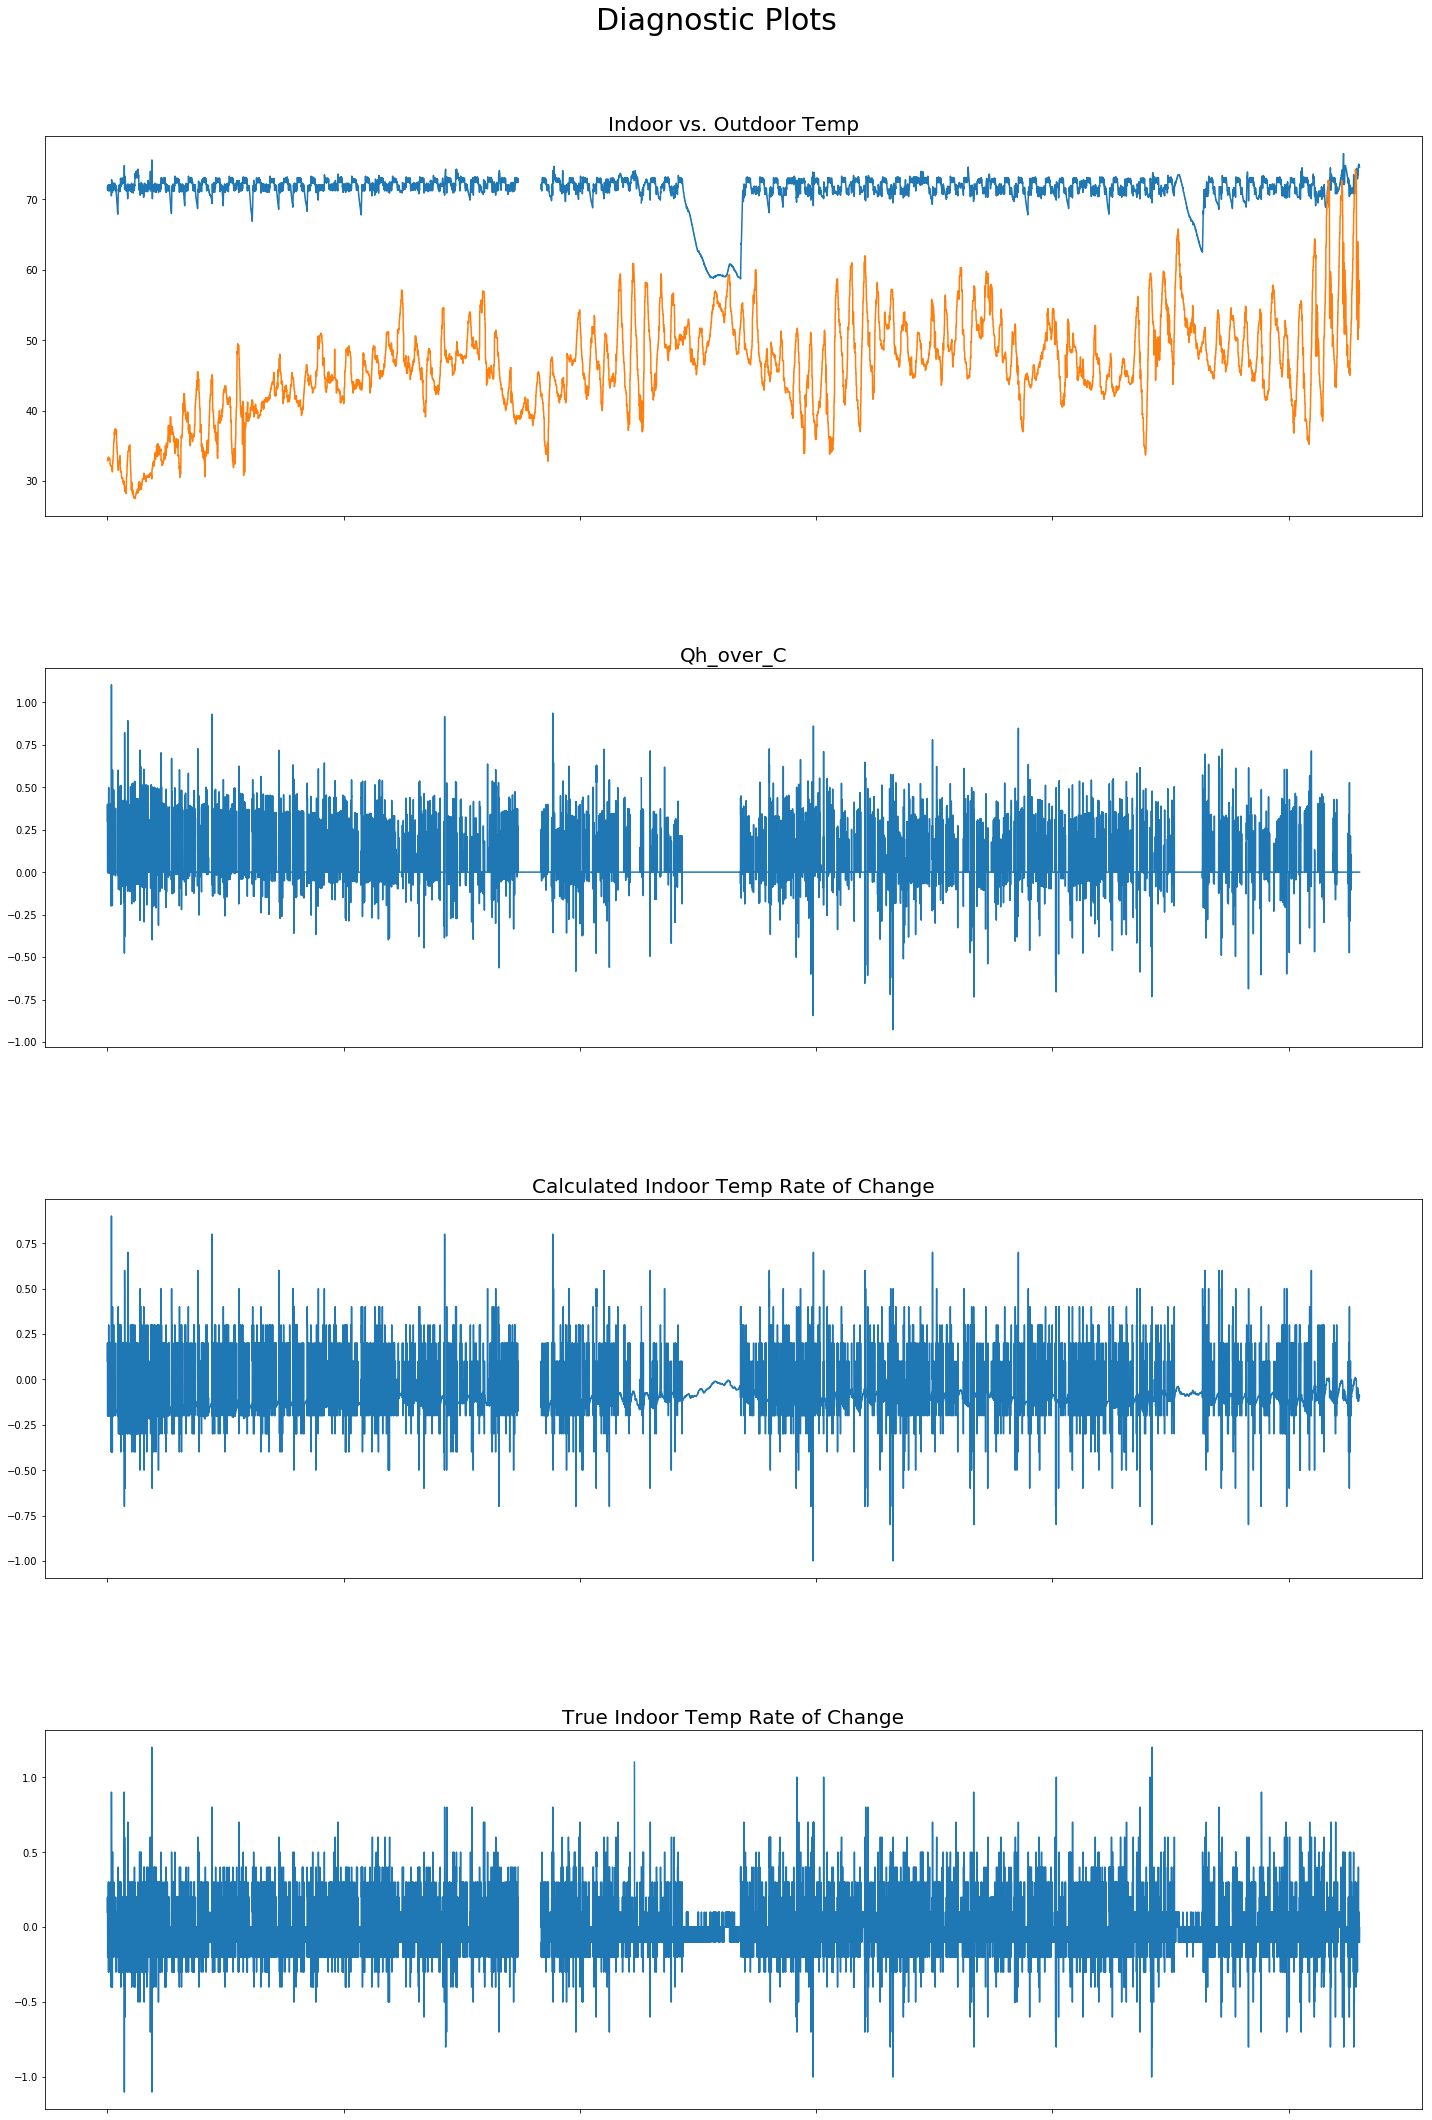

In [5]:
# somewhat arbitrary constants. Accuracy could be improved by deriving R and C from the data
R = 13
C = 15
model = efficiency_model(data, R, C)
Qh_over_C = model.energy_over_time()
test_dTin_dt, true_dTin_dt = model.test_model()
model.diagnostic_plots()

### What more could be done

 - Better plot labels
 - Probe reasons for missing data